In [1]:
from snn_delays.datasets.custom_datasets import CustomDataset
from snn_delays.config import DATASET_PATH
from torch.utils.data import DataLoader
import os

from snn_delays.utils.memory_cached_dataset import MemoryCachedDataset
import numpy as np

from snn_delays.snn_refactored import SNN
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple
from snn_delays.utils.test_behavior import tb_minimal
# from snn_delays.utils.visualization_utils import plot_taus
import numpy as np
device = get_device()

'''
4-word classification dataset (permuted without repetition)

in total, 24 classes

words = [
    "ABCD", "ABDC", "ACBD", "ACDB", "ADBC", "ADCB",
    "BACD", "BADC", "BCAD", "BCDA", "BDAC", "BDCA",
    "CABD", "CADB", "CBAD", "CBDA", "CDAB", "CDBA",
    "DABC", "DACB", "DBAC", "DBCA", "DCAB", "DCBA"
]

'''

#data = np.load(os.path.join(DATASET_PATH, 'raw_datasets', 'Letters', 'letter_classification_dataset.npz'))
data = np.load(os.path.join(DATASET_PATH, 'Letters', 'four_letter_classification_dataset.npz'))

train_data = data['train_data']
test_data = data['test_data']
train_labels= data['train_labels']
test_labels = data['test_labels']

num_samples = len(train_labels)

train_dataset = CustomDataset(train_data, train_labels)
test_dataset = CustomDataset(test_data, test_labels)

dataset_dict = train_dataset.get_train_attributes()

cached_train_dataset = MemoryCachedDataset(train_dataset, device=device)
cached_test_dataset = MemoryCachedDataset(test_dataset, device=device)

total_time = train_data.shape[1]
print(f'num timesteps per sample: {total_time}')
batch_size = 128

train_loader = DataLoader(cached_train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False,
                            pin_memory=False,
                            num_workers=0)

test_loader = DataLoader(cached_test_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False,
                            pin_memory=False,
                            num_workers=0)

dataset_dict["time_ms"] = 1e3
dataset_dict["dataset_name"] = "letters"

c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda:0
Initializing GPU cache for 9600 samples...
Cache initialized in 0.84 seconds
Initializing GPU cache for 2400 samples...
Cache initialized in 0.08 seconds
num timesteps per sample: 64


In [2]:
num_h = 64

time_window = 64

tau_m = 'log-uniform-st'

extra_kwargs = {'multifeedforward':3}
snn_f = SNN(dataset_dict, structure=(num_h, 2, 'mf'), win=time_window, tau_m=tau_m,
             loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_f.set_layers()
snn_f.to(device)

snn_vf = SNN(dataset_dict, structure=(num_h, 2, 'f'), win=time_window, tau_m=tau_m,
             loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False)

snn_vf.set_layers()
snn_vf.to(device)

snn_rnn = SNN(dataset_dict, structure=(num_h, 2, 'r'), win=time_window, tau_m=tau_m,
               loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False)

snn_rnn.set_layers()
snn_rnn.to(device)

extra_kwargs = {'delay_range':(18, 1),
                'pruned_delays': 3}

snn_rd = SNN(dataset_dict, structure=(num_h, 2, 'd'), win=time_window, tau_m=tau_m,
               loss_fn='mem_sum', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_rd.set_layers()
snn_rd.to(device)

Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms


SNN(
  (criterion): CrossEntropyLoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=25, out_features=64, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=1152, out_features=64, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=24, bias=False)
    )
  )
)

In [3]:
ckpt_dir = 'permuted_4letters_task'
num_epochs = 50

lr_tau = 0.1

train(snn_f, train_loader, test_loader, 1e-3, num_epochs, ckpt_dir=ckpt_dir, test_behavior=tb_minimal, 
      scheduler=(100, 0.95), lr_tau=lr_tau)
train(snn_vf, train_loader, test_loader, 1e-3, num_epochs, ckpt_dir=ckpt_dir, test_behavior=tb_minimal, 
      scheduler=(100, 0.95), lr_tau=lr_tau)
train(snn_rnn, train_loader, test_loader, 1e-3, num_epochs, ckpt_dir=ckpt_dir, test_behavior=tb_minimal, 
      scheduler=(100, 0.95), lr_tau=lr_tau)
train(snn_rd, train_loader, test_loader, 1e-3, num_epochs, ckpt_dir=ckpt_dir, test_behavior=tb_minimal, 
      scheduler=(100, 0.95), lr_tau=lr_tau)

Epoch [1/50], learning_rates 0.001000, 0.100000


c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [25/75], Loss: 4.69819
Step [50/75], Loss: 3.48666
Step [75/75], Loss: 3.34176
Time elasped: 22.75199317932129
Epoch [2/50], learning_rates 0.001000, 0.100000
Step [25/75], Loss: 3.23685
Step [50/75], Loss: 3.26675
Step [75/75], Loss: 3.19268
Time elasped: 19.978158950805664
Epoch [3/50], learning_rates 0.001000, 0.100000
Step [25/75], Loss: 3.22734
Step [50/75], Loss: 3.19065
Step [75/75], Loss: 3.24209
Time elasped: 20.058351755142212
Epoch [4/50], learning_rates 0.001000, 0.100000
Step [25/75], Loss: 3.19315
Step [50/75], Loss: 3.23690
Step [75/75], Loss: 3.22234
Time elasped: 20.037115573883057
Epoch [5/50], learning_rates 0.001000, 0.100000
Step [25/75], Loss: 3.17048
Step [50/75], Loss: 3.19835
Step [75/75], Loss: 3.11737
Time elasped: 20.589317321777344
2400
Test Loss: 3.1993209437320105
Avg spk_count per neuron for all 64 time-steps 172.42458333333335
Test Accuracy of the model on the test samples: 4.667

max acc: 4.666666666666667
Epoch [6/50], learning_rates 0.001000, 0.

Text(0.5, 1.0, 'train loss')

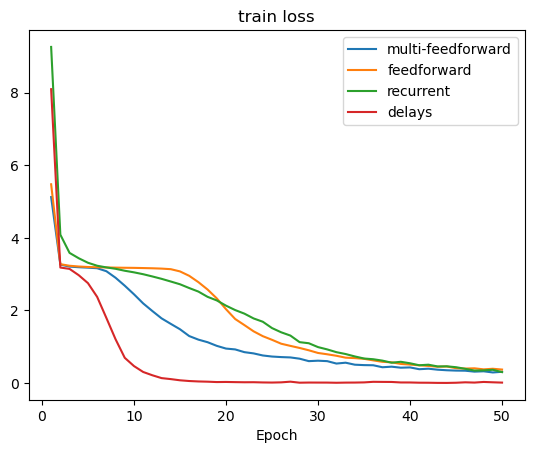

In [4]:
import numpy as np
from snn_delays.utils.visualization_utils import plot_per_epoch
import matplotlib.pyplot as plt

plot_per_epoch(snn_f.train_loss, label = 'multi-feedforward')
plot_per_epoch(snn_vf.train_loss, label = 'feedforward')
plot_per_epoch(snn_rnn.train_loss, label = 'recurrent')
plot_per_epoch(snn_rd.train_loss, label = 'delays')
#plt.title(f'loss error = {loss_error}')
plt.title('train loss')

In [5]:
snn_f.debug = True
snn_rnn.debug = True
snn_rd.debug = True
snn_vf.debug = True
snn_f.init_state_logger()
snn_rnn.init_state_logger()
snn_rd.init_state_logger()
snn_vf.init_state_logger()


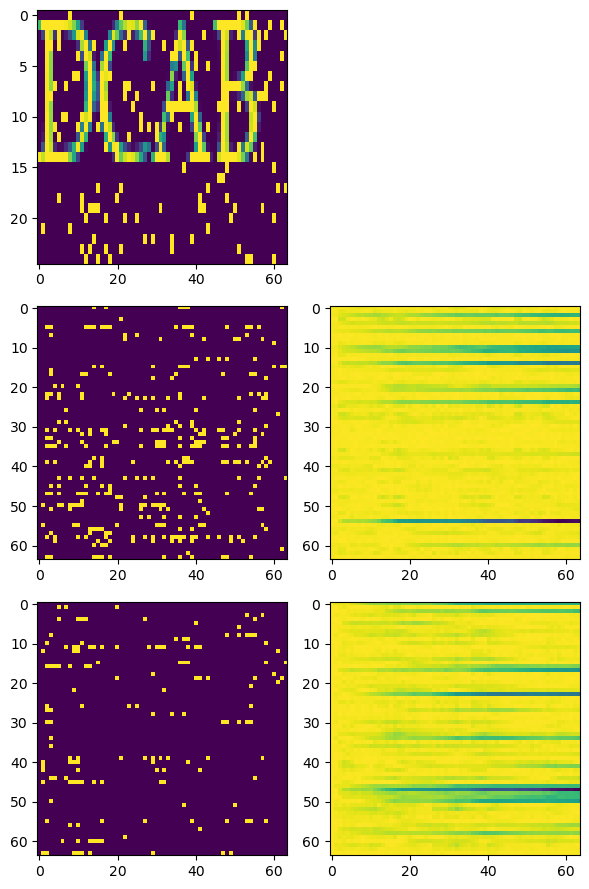

In [6]:
images, _ = propagate_batch_simple(snn_f, test_loader)
spk = snn_f.spike_state
mem = snn_f.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N, :, 0, :].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

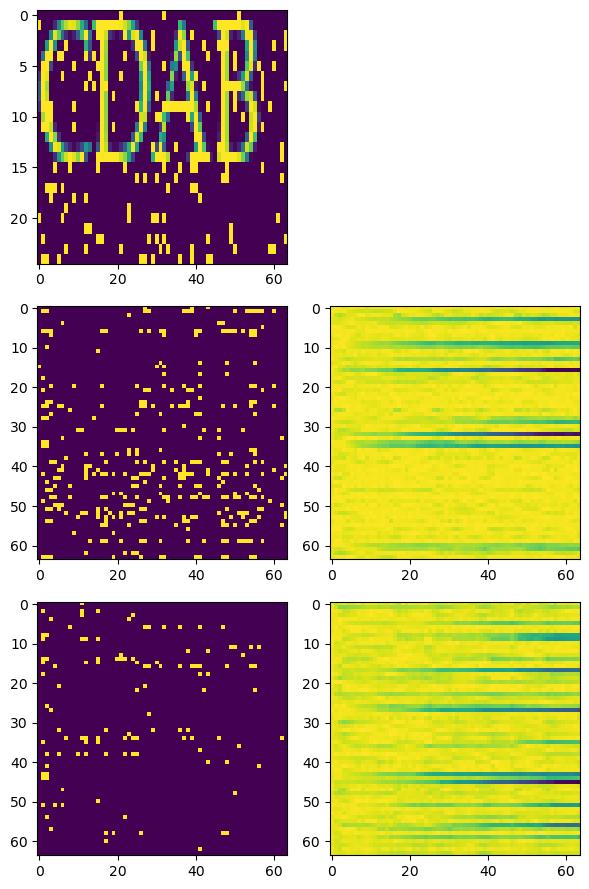

In [7]:
images, _ = propagate_batch_simple(snn_vf, test_loader)
spk = snn_vf.spike_state
mem = snn_vf.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N, :, 0, :].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

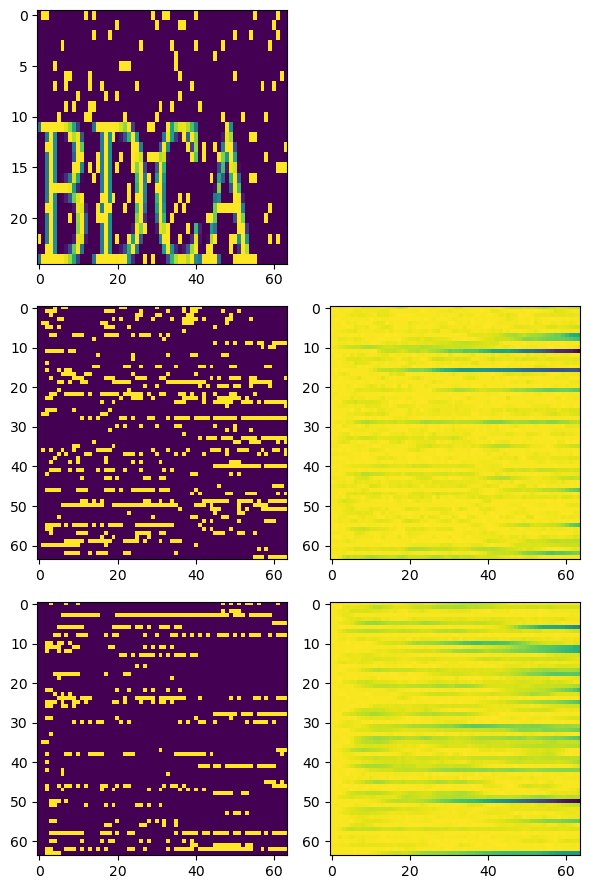

In [8]:
images, _ = propagate_batch_simple(snn_rnn, test_loader)
spk = snn_rnn.spike_state
mem = snn_rnn.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N, :, 0, :].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

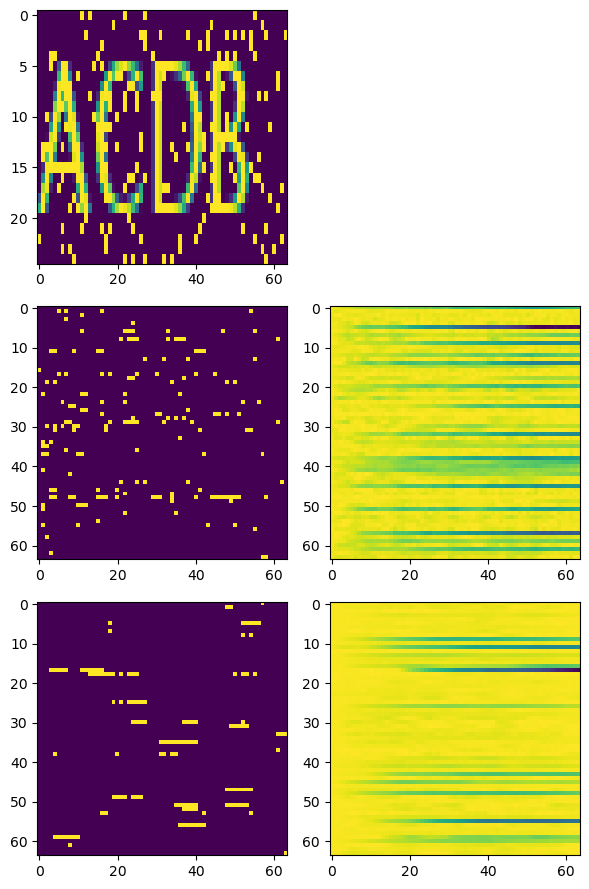

In [9]:
images, _ = propagate_batch_simple(snn_rd, test_loader)
spk = snn_rd.spike_state
mem = snn_rd.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N, :, 0, :].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

In [10]:
snn_f.save_model('snn_mf', ckpt_dir)
snn_rnn.save_model('snn_rnn', ckpt_dir)
snn_rd.save_model('snn_rd', ckpt_dir)
snn_vf.save_model('snn_f', ckpt_dir)

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\permuted_4letters_task
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\permuted_4letters_task
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\permuted_4letters_task
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\permuted_4letters_task


In [22]:
from snn_delays.utils.model_loader_refac import ModelLoader
ckpt_dir = 'permuted_letters_task'
snn_mf = ModelLoader('snn_mf', ckpt_dir, 128, 'cuda')
snn_rnn = ModelLoader('snn_rnn', ckpt_dir, 128, 'cuda')
snn_rd = ModelLoader('snn_rd', ckpt_dir, 128, 'cuda')

Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Delta t: 15.625 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully


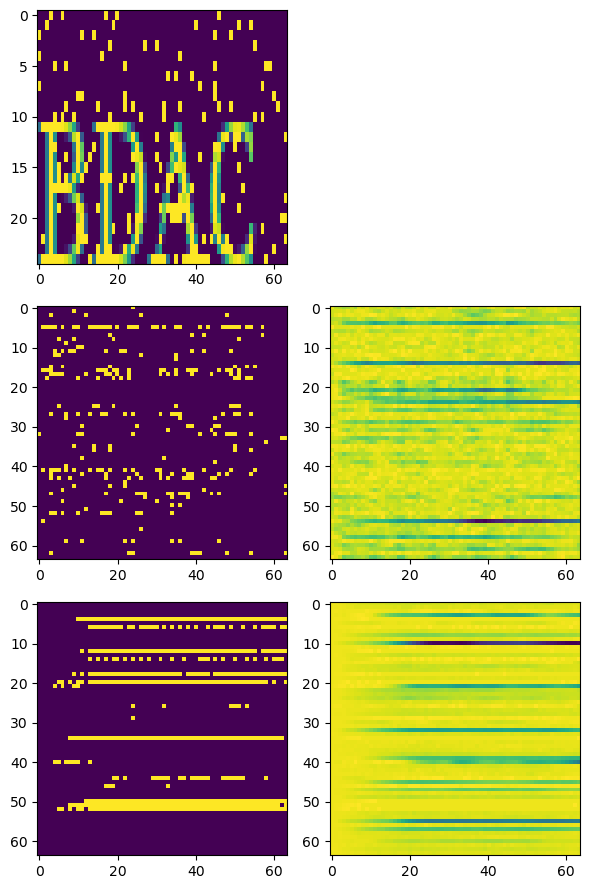

In [24]:
snn_f.debug = True
snn_rnn.debug = True
snn_rd.debug = True
snn_f.init_state_logger()
snn_rnn.init_state_logger()
snn_rd.init_state_logger()

images, _ = propagate_batch_simple(snn_rd, test_loader)
spk = snn_rd.spike_state
mem = snn_rd.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N, :, 0, :].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()